In [1]:
from stackapi import StackAPI
from langdetect import detect
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud
from gensim import corpora
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\milan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
def df_save(min_score=10, min_tags=2, max_tags=8, min_title_length=10, max_title_length=100, save_path="data_new.csv"):
    SITE = StackAPI('stackoverflow')
    SITE.max_pages = 25
    SITE.page_size = 100
    
    try:
        df_existing = pd.read_csv(save_path)
        all_data = df_existing.to_dict('records')
        print(f"Reprise de la collecte. {len(df_existing)} lignes déjà récupérées.")
        current_min_score = df_existing['score'].min()
    except FileNotFoundError:
        all_data = []
    
    start_date = datetime.datetime(2018, 1, 1) 
    end_date = datetime.datetime(2019, 12, 31)
    
    delta = datetime.timedelta(days=20)
    
    current_start = start_date
    
    while current_start < end_date:
        print("start")
        current_end = min(current_start + delta, end_date)

        fromdate = int(current_start.timestamp())
        todate = int(current_end.timestamp())
    
        try:

            questions = SITE.fetch('questions',
                                   fromdate=fromdate,
                                   todate=todate,
                                   min=min_score,
                                   sort='votes',
                                   )
        except Exception as e:
            print(f"Error fetching questions from {current_start} to {current_end}: {e}")
            time.sleep(5)
            return
        
        data = []
        print("questions")
        for question in questions['items']:

            if (min_tags <= len(question.get('tags', [])) <= max_tags and
                min_title_length <= len(question.get('title', '')) <= max_title_length):
                data.append({
                    'title': question['title'],
                    'score': question['score'],
                    'tags': ','.join(question['tags']),
                    'creation_date': datetime.datetime.fromtimestamp(question['creation_date']).isoformat(),
                })
        all_data.extend(data)
        print("extend")
        df_filtered = pd.DataFrame(all_data)
        df_filtered.to_csv(save_path, index=False)
        print(f"{len(data)} lignes récupérées de {current_start} à {current_end}.")
        print(f"{len(all_data)} lignes sauvegardées dans {save_path}.")       
    
        current_start = current_end
        time.sleep(0.2)


Possible Filter to get consistant data for tag prediction :
- By the score
- by the number of tags
- Temporality
- title(question) size
- by the popularity(view)
- language
- 

In [ ]:
df = df_save()

In [3]:
df = pd.read_csv("data_new.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60320 entries, 0 to 60319
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          60320 non-null  object
 1   score          60320 non-null  int64 
 2   tags           60320 non-null  object
 3   creation_date  60320 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.8+ MB


In [5]:
df.describe()

,score
count,60320.000000
mean,24.164788
std,37.057723
min,10.000000
25%,12.000000
50%,15.000000
75%,24.000000
max,2694.000000


delete dup title

In [6]:
df.drop_duplicates('title', inplace=True)
df.duplicated('title').sum()

0

In [7]:
class TextPreprocessor:
    def __init__(self, df, commun=3):
        self.df = df
        self.stop_words = set(stopwords.words('english'))
        self.stop_words_strict = None
        self.lemmatizer = WordNetLemmatizer()
        self.commun = commun
        self.less_common = None

    def is_english(self, text):
        try:
            return detect(text) == 'en'
        except:
            return False

    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'(?<!\bc)(\+|#)', '', text)
        text = re.sub(r'[^a-z\s\+#]', '', text)

        
        words = text.split()
        words = [word for word in words if word not in self.stop_words]
        return ' '.join(words)
    
    def clean_text_strict(self, text):
        text = text.lower()
        text = re.sub(r'(?<!\bc)(\+|#)', '', text)
        text = re.sub(r'[^a-z\s\+#]', '', text)

        
        words = text.split()
        words = [word for word in words if word not in self.stop_words_strict]
        return ' '.join(words)

    def clean_common(self, text, frequent_words):
        words = text.split()
        words = [word for word in words if word not in frequent_words]
        return ' '.join(words)

    def lemmatize_text(self, text):
        words = text.split()
        lemmatized_words = [self.lemmatizer.lemmatize(word) for word in words]
        return ' '.join(lemmatized_words)

    def clean_df(self):
        self.df['is_english'] = self.df['title'].apply(self.is_english)
        self.df= self.df[self.df['is_english'] == True].copy()
        self.df.loc[:, 'cleaned_title'] = self.df['title'].apply(lambda x: self.clean_text(x))
        if self.stop_words_strict is not None:
            self.df.loc[:, 'cleaned_title_strict'] = self.df['title'].apply(lambda x: self.clean_text_strict(x))
        self.plot_words()
        all_words = [word for title in self.df['cleaned_title'].str.split() for word in title]
        words, counts = zip(*Counter(all_words).most_common(self.commun))
        print(words)
        self.df.loc[:, 'cleaned_title'] = self.df['cleaned_title'].apply(lambda x: self.clean_common(x, words))
        self.take_words_not_common()
        self.df.loc[:, 'cleaned_title'] = self.df['cleaned_title'].apply(lambda x: self.clean_common(x, self.less_common))
        if self.stop_words_strict is not None:
            self.df.loc[:, 'cleaned_title_strict'] = self.df['cleaned_title_strict'].apply(lambda x: self.clean_common(x, self.less_common))
        if self.stop_words_strict is not None:
            self.df.loc[:, 'cleaned_title_strict'] = self.df['cleaned_title_strict'].apply(lambda x: self.clean_common(x, words))
        self.plot_words()
    
    def transform(self):
        self.clean_df()
        self.df.loc[:, 'lm'] = self.df['cleaned_title'].apply(lambda x: self.lemmatize_text(x))
        return self.df
    
    def plot_WordCloud(self):
        if 'cleaned_title' not in self.df.columns:
            all_words = [word for title in self.df['title'] \
                if isinstance(title, str) for word in title.split()]
        else:
            all_words = [word for title in self.df['cleaned_title'] \
                if isinstance(title, str) for word in title.split()]
        c = Counter(all_words)
        word_counts = {word: count for word, count in c.items()}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Most Frequent Words in Titles', fontsize=16)
        plt.show()
        
    def plot_words(self, column='cleaned_title'):
        if column not in self.df.columns:
            all_words = [word for title in self.df['title'].str.split() for word in title]
        else:
            all_words = [word for title in self.df[column].str.split() for word in title]
        words, counts = zip(*Counter(all_words).most_common(200))
        plt.figure(figsize=(40, 6))
        plt.bar(words, counts, color='skyblue')
        plt.title('Top 200 Most Frequent Words in Titles', fontsize=15)
        plt.ylabel('Frequency', fontsize=12)
        plt.xlabel('Words', fontsize=12)
        plt.xticks(rotation=90, ha='right', fontsize=10)
        plt.tight_layout()
        plt.show()

    def take_words_not_common(self):
        if 'cleaned_title' not in self.df.columns:
            all_words = [word for title in self.df['title'].str.split() for word in title]
        else:
            all_words = [word for title in self.df['cleaned_title'].str.split() for word in title]
        word_counts = Counter(all_words)
        self.less_common = [word for word, count in word_counts.items() if count <= 10]

    def get_less_common(self):
        return self.less_common
        
    def add_stop_words(self, words):
        self.stop_words_strict = set(self.stop_words)
        self.stop_words_strict.update(words)
    
    def plot_tags(self):
        if 'tags_split' not in self.df.columns:
            self.df['tags_split'] = self.df['tags'].str.split(',')
        all_tags = [tag for sublist in self.df['tags_split'] for tag in sublist]
        tag_counts = pd.Series(all_tags).value_counts()
        plt.figure(figsize=(12, 6))
        tag_counts.head(30).plot(kind='bar')
        plt.title('Top 30 Most Frequent Tags')
        plt.ylabel('Frequency')
        plt.xlabel('Tags')
        plt.xticks(rotation=70)
        plt.tight_layout()
        plt.show()
        
    def boxplot_scores(self):
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=self.df, x='score')
        plt.title('Boxplot of Question Scores')
        plt.xlabel('Score')
        plt.show()
    def get_data(self):
        return self.df

In [8]:
TP = TextPreprocessor(df.copy())


In [9]:
new_stopword = ['get', 'use', 'way', 'would', 'like', 'one', 'need', 'know', 'make', 'using', \
    'want', 'work', 'code', 'example', 'function', 'value', 'problem', 'user', 'data', 'file', 'time', \
    'set', 'return', 'string', 'method', 'class', 'object', 'found', 'type', 'run', 'try', 'new', 'create', \
    'two', 'call', 'spring', 'app', 'save', 'work', 'change', 'another', 'directory', 'used', 'testing', 'test', \
    'operator', 'open', 'update', 'variable', 'package', 'template', 'cant', 'check', 'version', 'resolve', 'null', \
    'memory', 'dependency', 'list', 'images', 'issue', 'packages', 'loading', 'row', 'rows', 'column', 'cannot', 'property', \
    'properties', 'doesnt', 'size', 'undefined', 'read', 'objects', 'typeerror', 'specific', 'default', 'table', 'library', 'fix', \
    'command', 'custom', 'service', 'functions', 'warning', 'whats', 'static', 'fails', 'text', 'permission', 'values', 'array', 'arrays', \
    'remove', 'name', 'find', 'unable', 'failed', 'could', 'query', 'tests', 'instance', 'response', 'order', 'creating', 'files', 'getting', \
    'via', 'input', 'local', 'exception', 'page', 'available', 'running', 'parameter', 'character', 'characters', 'possible', 'form', 'always', \
    'changes', 'group', 'post', 'correctly', 'show', 'path', 'arguments', 'constructor',  'target', 'compile', 'requests', 'project', 'pass', \
    'deprecated', 'instead', 'single', 'output', 'key', 'types', 'format', 'connection', 'date', 'support', 'debug', 'map', 'mode', 'tab', 'number', \
    'start', 'trying', 'configuration', 'build', 'image', 'based', 'working', 'color', 'attribute', 'index', 'multiple', 'showing', 'select', 'columns', \
    'updating', 'different', 'load', 'actions', 'expected', 'element', 'within', 'prevent', 'message', 'body', 'prevent', 'difference', 'import', \
    'missing', 'extension', 'send', 'download', 'content', 'add', 'core', 'access', 'remove', 'delete', 'click', 'display', 'check', 'passing', 'pass', \
    'module', 'modules', 'without', 'install', 'installed', 'access', 'inside', 'outside', 'convert', 'converts', 'material', 'line', 'lines', 'navigation', \
    'field', 'fields', 'button', 'buttons', 'event', 'events', 'variables', 'variable', 'properties', 'property', 'state', 'states', 'connect', 'connected', \
    'script', 'reference', 'screen', 'arguments', 'argument', 'parameter', 'parameters', 'background', 'backgrounds', 'store', 'stored', 'stores', 'store', \
    'adding', 'invalid', 'valid', 'validity', 'validate', 'validation', 'validating', 'validated', 'validates', 'validations', 'validation', 'dynamic', \
    'dynamically', 'folder', 'defined', 'define', 'context', 'installing', 'errors', 'current', 'empty', 'console', 'best', 'must', 'option', 'plugin' \
    'action', 'actions', 'source', 'id', 'generate', 'generating', 'generated', 'generates', 'handle', 'handling', 'handled', 'handles', 'elements', 'element', \
    'named', 'exist', 'exists', 'existing', 'unit', 'units', 'installed', 'implement', 'implements', 'implemented', 'implementing', 'implementations', 'implementation', \
    'called', 'detect', 'detects', 'detected', 'detecting', 'detectable', 'detectability', 'display', 'displays', 'displayed', 'displaying', 'displayable', 'displayability', \
    'header', 'headers', 'loop', 'loops', 'looped', 'looping', 'loopable', 'loopability', 'storage', 'storages', 'stored', 'storing', 'store', 'storeable', 'storeability', \
    'play', 'bar', 'unknown', 'setting', 'settings', 'set', 'settable', 'log', 'logs', 'icon', 'cache', 'caches', 'required', 'require', 'requires', 'requiring', 'requirement', \
    'modules', 'enable', 'enables', 'enabled', 'enabling', 'enablement', 'disable', 'disables', 'disabled', 'disabling', 'disablement', 'disableable', 'disableability', 'disablement', \
    'process', 'processes', 'processed', 'processing', 'processable', 'processability', 'processable', 'processability', 'processable', 'processability', 'processable', 'processability', \
    'task', 'dependencies', 'configure', 'child', 'specify', 'item', 'existing', 'height', 'width', 'length', 'size', 'color', 'colors', 'heights', 'widths', 'lengths', 'sizes', 'colors', \
    'returns', 'returning', 'returned', 'supported', 'supporting', 'supports', 'supportable', 'supportability', 'copy', 'copies', 'copied', 'copying', 'copyable', 'copyability', 'copyable'\
    'config', 'configs', 'configured', 'configuring', 'configurable', 'configurability', 'link', 'links', 'linked', 'linking', 'linkable', 'linkability', 'system', 'systems', 'equivalent',\
    'include', 'unexpected', 'back', 'next', 'push', 'filter', 'automatically', 'generic', 'even', 'status', 'every', 'search', 'setup', 'changing', 'solve', 'correct', 'already'  \
    'export', 'result', 'parent', 'login', 'expression', 'expressions', 'expressed', 'expressing', 'expressable', 'external', 'results', 'position', 'positions', 'positioned', 'positioning', \
    'avoid', 'tag', 'match', 'replace', 'release', 'layout', 'schema', 'slow', 'fast', 'quick', 'slowly', 'quickly', 'fastly', 'slowest', 'fastest', 'quickest', 'slowly', 'quickly', 'fastly', \
    'performance', 'stop', 'items', 'work', 'works', 'hide', 'v', "works", "record", "tools", "execute", "plugin", "behavior", "redirect", "style", "full", "changed", "failure", "apply", "architecture"\
    "preview", "limit", "share", "crashes", "contain", "denied", "base", "public", "dictionary", "config", "scrolling", "big", "put", "document", "force", "pages", "pdf", "separate", "range", "definition"\
    "created", "locally", "efficient", "hide", "large", "hooks", "credentials", "properly", "purpose", "internal", "causes", "end", "converting", "manually", "libraries", "font", "point" \
    "repository", "account", "shows", "notification", "keep", "inject", "cypress" , "hash", "upload", "export", "keys", "see", "long", "space", "main", "services", "clear", "callback", \
    "authentication", "auto", "autocomplete", "differences", "engine", "still", "additional", "video", "throws", "usage", "deployment", "reading", "assets", "prompt",\
    "architecture", "location", "exactly", "false", "faster", "black", "second", "true", "platform", "classes", "calling", "level", "wrong", "entity", "certain", "move", \
    "execution", "trigger", "website", "preview", "virtual", "simple", "verify", "pull", "projects", "debugging", "per", "statement", "split", "exit", "crash", "step", \
    "contains", "pod", "airflow", "vector", "left", "private", "right", "case", "issues", "attributes", "hint", "failing", "retrieve", "gateway", "matrix", "stream", "password", \
    "write", "standard", "definition", "syntax", "bottom", "signature", "fetch", "security", 'blob', "border", "gives", "block", "collection", "active", "align", "practice",\
    "boolean", "es", "condition", "isnt", "cause", "exclude", "graph", "reset", "remote", "groupby", "imported", "beta", "wait", "names", "timezone", "boolean", "scope", "last",\
    "previous", "view", "first", "entity", "combine", "await", "member", "execution", "vector", "observable", "idea", "shared", "pull", "resource", "latest", "numbers", "isnt", \
    "device", "coverage", "tags", "maps", "close", "review", "created", "calling", "take", "signature", "signed", "got", "exactly", "groupby", "datetime", "assign", "functional", \
    "opened", "activity", "definition"]
TP.add_stop_words(new_stopword)

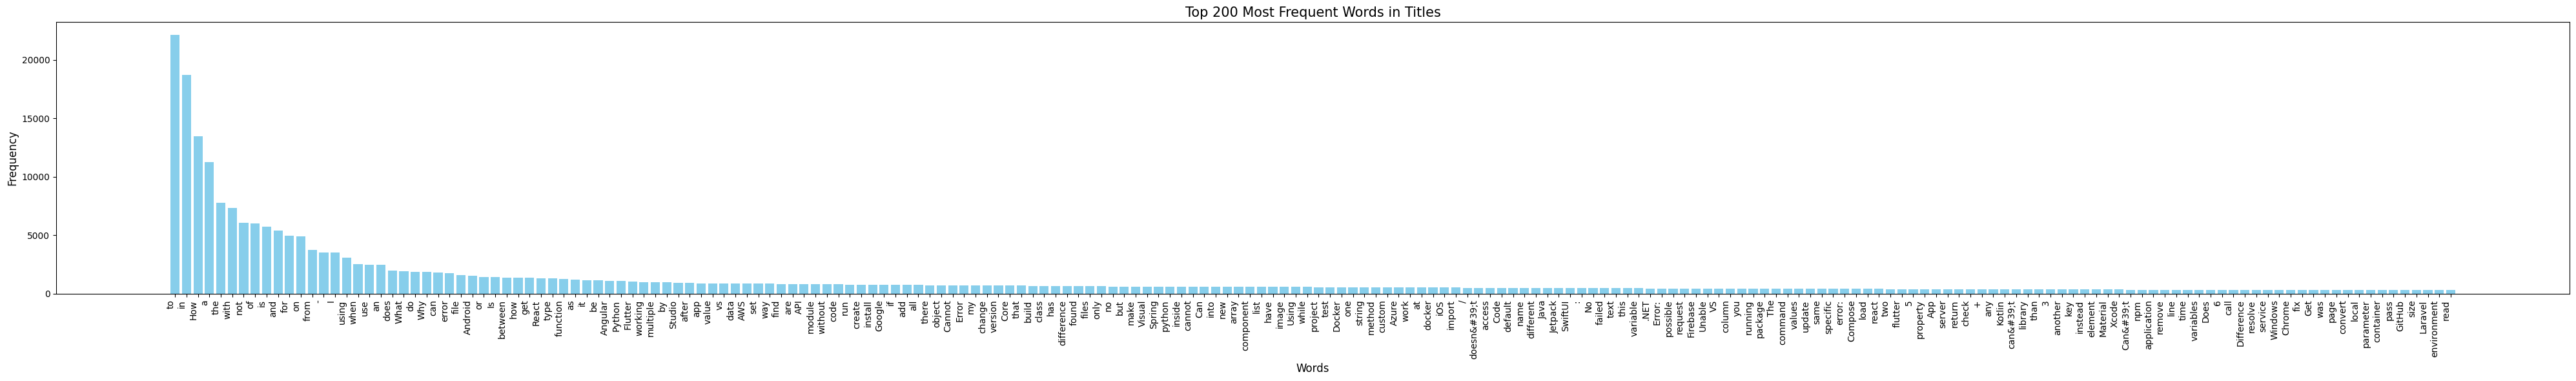

In [10]:
TP.plot_words()

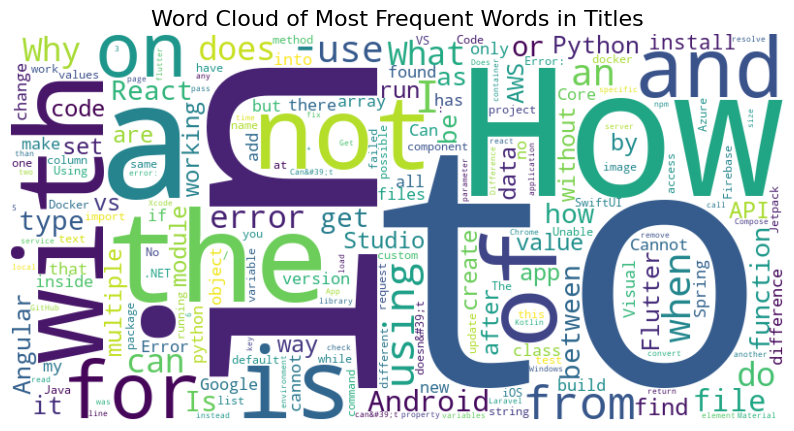

In [15]:
TP.plot_WordCloud()

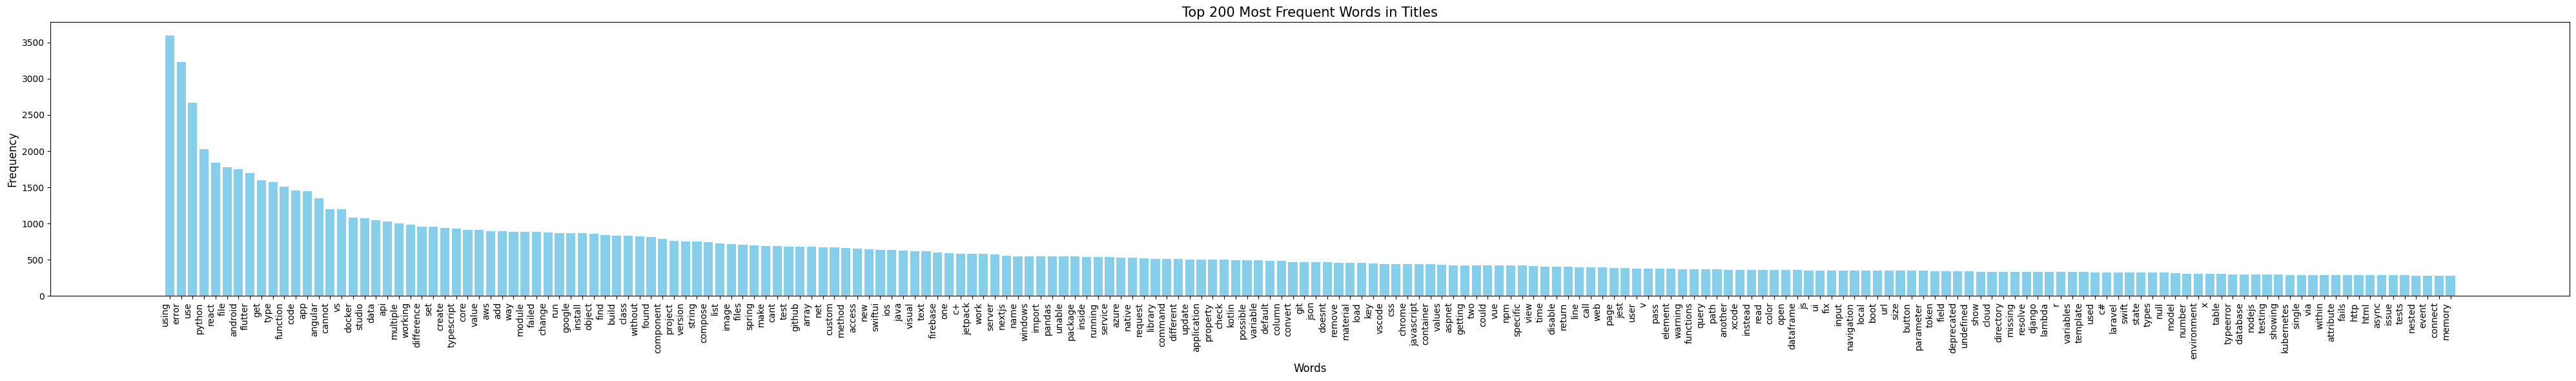

('using', 'error', 'use')


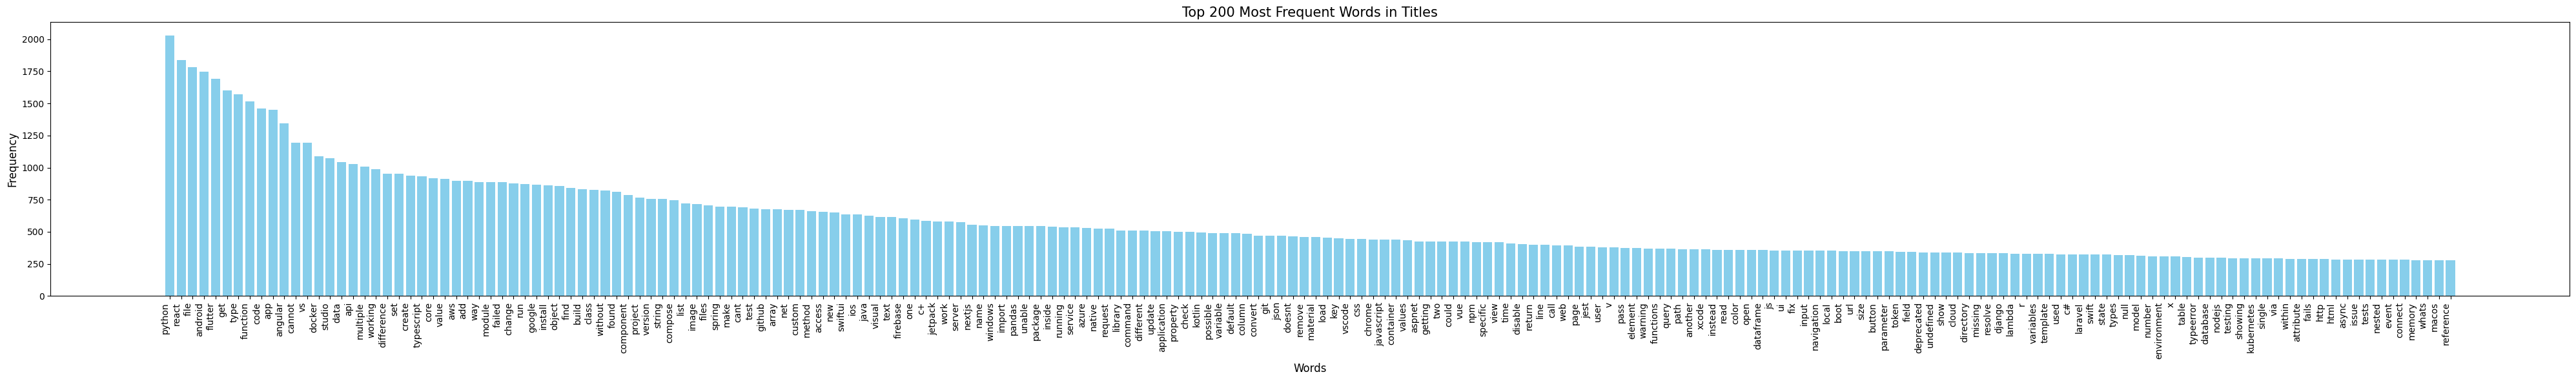

In [11]:
TP.transform()
print("\n")

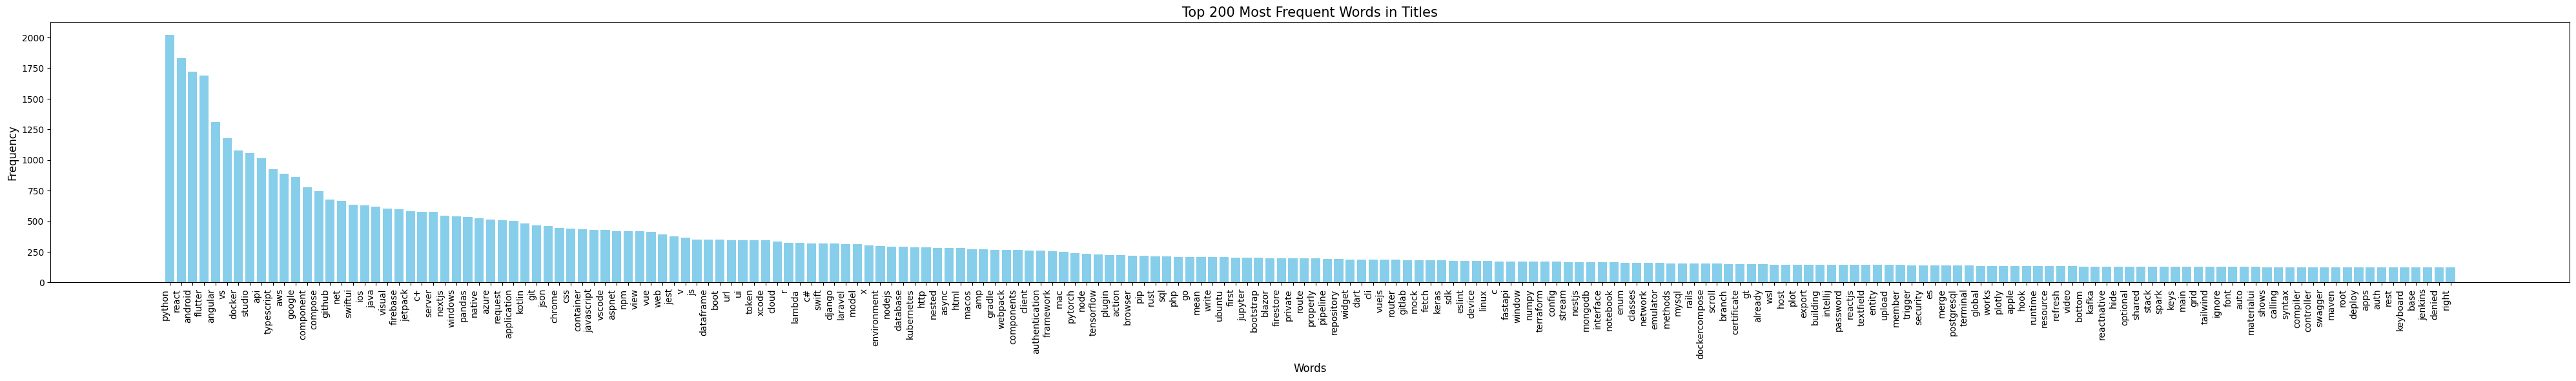

In [24]:
TP.plot_words('cleaned_title_strict')

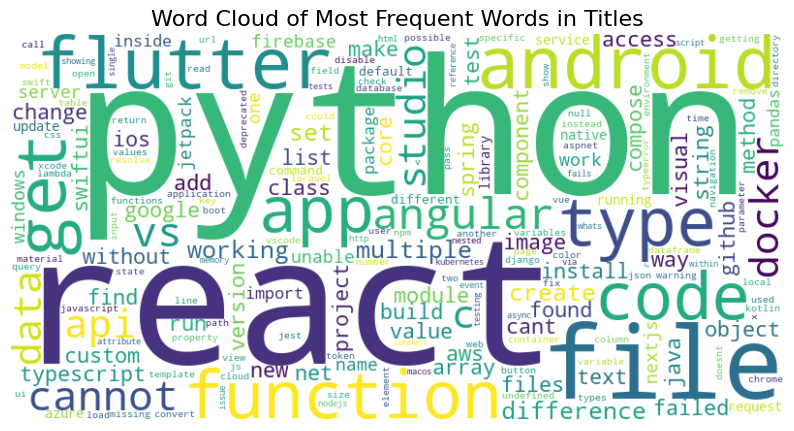

In [60]:
TP.plot_WordCloud()

In [12]:
X_clean = TP.get_data()
X_clean.head()


,title,score,tags,creation_date,is_english,cleaned_title,cleaned_title_strict,lm
0,How can I use optional chaining with arrays an...,321,"javascript,arrays,typescript,function,optional...",2020-01-07T08:05:02,True,optional chaining arrays functions,optional chaining,optional chaining array function
1,What is the use of PYTHONUNBUFFERED in docker ...,308,"django,docker,dockerfile",2020-01-19T17:23:11,True,docker file,docker,docker file
2,IntelliJ: Error:java: error: release version 5...,282,"java,intellij-idea",2020-01-05T15:54:15,True,intellij release version supported,intellij,intellij release version supported
3,Maven dependencies are failing with a 501 error,220,"java,maven,jenkins,maven-central",2020-01-16T06:31:52,True,maven dependencies failing,maven,maven dependency failing
4,react-testing-library: some portion of debug&#...,205,"javascript,reactjs,jestjs,react-testing-library",2020-01-16T06:54:02,True,reacttestinglibrary output visible,reacttestinglibrary visible,reacttestinglibrary output visible


In [13]:
print(X_clean[X_clean['is_english'] == True].shape)

(55813, 8)


In [14]:
print(X_clean[X_clean['cleaned_title'].str.len() == 0].shape)
print(X_clean[X_clean['cleaned_title_strict'].str.len() == 0].shape)
X_clean = X_clean[X_clean['cleaned_title_strict'].str.len() >= 0].copy()

(311, 8)
(3472, 8)


In [16]:
print(X_clean[X_clean['cleaned_title_strict'].str.len() == 1])

                                                   title  score  \
2150              Is 35k rows/s slow or fast for EdgeDB?     11   
3144       R package patchwork : titles for rows/columns     12   
3918   Stitch images and data from coupled microscopy...     17   
4255       Benchmarking &quot;sample&quot; function in R     11   
6099        tcp_input [C5.1:3] flags=[R.] seq=2934102331     14   
...                                                  ...    ...   
54991  What is the n parameter of tkinter.mainloop fu...     20   
56754                   Is &amp;*NULL well-defined in C?     26   
57160            VimDiff E93: More than one match for RE     17   
58476           What can R do about a messy data format?     50   
60114               Set path to miktex for pdflatex in R     10   

                                                    tags        creation_date  \
2150                         database,performance,edgedb  2020-02-05T02:19:02   
3144                             

In [17]:
print(X_clean)

                                                   title  score  \
0      How can I use optional chaining with arrays an...    321   
1      What is the use of PYTHONUNBUFFERED in docker ...    308   
2      IntelliJ: Error:java: error: release version 5...    282   
3        Maven dependencies are failing with a 501 error    220   
4      react-testing-library: some portion of debug&#...    205   
...                                                  ...    ...   
60315  Makefile passing additional arguments to targe...     10   
60316                 Extract substring in R using grepl     10   
60317               What is &lt;.got&gt; section in ELF?     10   
60318  How can I make nested markdown bullet lists ha...     10   
60319    Error when selecting a dropdown item in Flutter     10   

                                                    tags        creation_date  \
0      javascript,arrays,typescript,function,optional...  2020-01-07T08:05:02   
1                               d

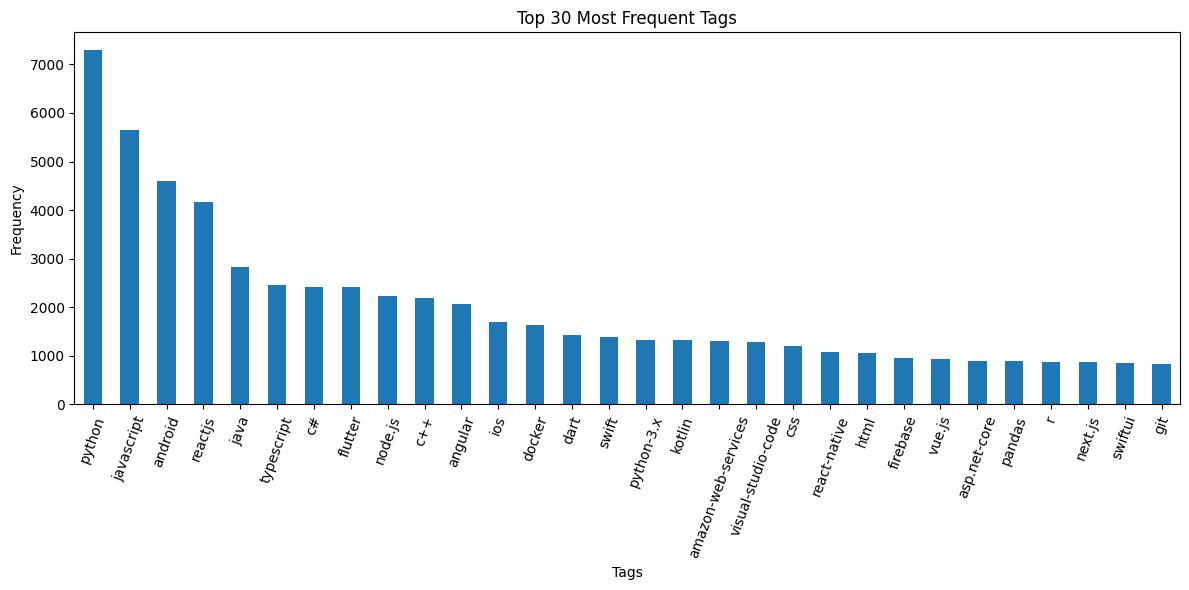

In [76]:
TP.plot_tags()

In [15]:
X_clean.to_csv("X_clean.csv")


In [16]:
print(X_clean.isna().sum())

title                   0
score                   0
tags                    0
creation_date           0
is_english              0
cleaned_title           0
cleaned_title_strict    0
lm                      0
dtype: int64
